# Ejercicio 05

In [1]:
import numpy as np

In [27]:
import matplotlib.pyplot as plt

## Lectura de la imagen original

In [65]:
from skimage.io import imread

In [ ]:
from skimage.io import imsave

In [159]:
original_image = imread('../resources/mono.bmp')

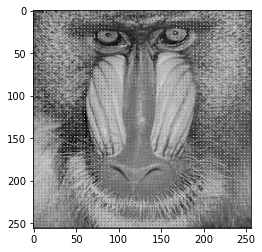

In [160]:
_ = plt.imshow(original_image, cmap='gray')

In [161]:
print(f'El tamaño original es {original_image.shape}')

El tamaño original es (256, 256)


## Decimación de la imagen
La **decimación** consiste en disminuir la frecuencia de muestreo, es decir, disminuir la cantidad de muestras que en este caso corresponden a píxeles de la imagen. Además, se puede aplicar algún procesamiento particular para determinar cómo generar los píxeles nuevos. En esta sección, se aplicará decimación escogiendo píxeles de posiciones particulares, o encontrando el valor promedio de los píxeles.

In [125]:
from skimage.measure import block_reduce

In [126]:
def extract_position(block: np.array, x: int, y: int):
    """ Returns a specific position from the given pixel block.
        @param block Pixel block of arbitrary shape
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns the pixel content
    """
    if x >= block.shape[0] or y >= block.shape[1]:
        raise ValueError('Coordinates out of the block')
    return block[x, y]

def extract_position_from_blocks(blocks: np.array, x: int, y: int) -> np.array:
    """ Receives a numpy array of arbitrary shape containing pixel blocks of a given size
        and extracts a particular position or pixel. Returns the same numpy array of arbitrary
        shape replacing each pixel block with the corresponding extracted pixel.
        @param blocks Numpy array of pixel blocks
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns a numpy array
    """
    new_blocks = np.zeros((blocks.shape[0], blocks.shape[1]))
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            new_blocks[i, j] = extract_position(blocks[i, j], x, y)
    return new_blocks

In [127]:
image_a = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 1, 1))

In [128]:
image_b = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 0, 0))

In [129]:
image_c = block_reduce(original_image, block_size=(4, 4), func=np.mean)

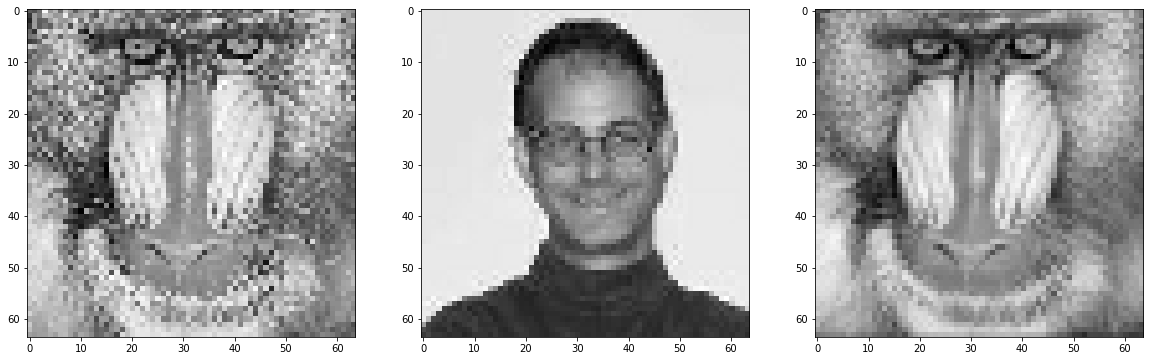

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a, cmap='gray')
ax[1].imshow(image_b, cmap='gray')
ax[2].imshow(image_c, cmap='gray')
plt.show()

## Interpolación Bilineal

In [184]:
def bilinear_interpolator(image, upsampling_factor):
    """ Upsamples an image applying the bilinear interpolation.
        @param image Original image
        @param upsampling_factor Upsampling factor
        @return Interpolated image
    """
    # Fetch the original shape and create the new shape
    input_x, input_y = image.shape
    output_x = int(input_x * upsampling_factor)
    output_y = int(input_y * upsampling_factor)
    # Create the new image with zeros
    output_image = np.zeros((output_x, output_y))
    for i in range(output_x):           #Iterate in cols
        for j in range(output_y):       #Iterate in rows
            aux_x = i / upsampling_factor
            aux_y = j / upsampling_factor
            # Search for the 4 points used for the interpolation
            x1 = int(aux_x)
            y1 = int(aux_y)
            x2 = x1
            y2 = y1 + 1
            x3 = x1 + 1
            y3 = y1
            x4 = x1 + 1
            y4 = y1 + 1
            x = aux_x - x1
            y = aux_y - y1
            # When the iteration is already in the limit of the image
            if x4 >= input_x:
                x4 = input_x - 1
                x3 = x4
                x2 = x4 - 1
                x1 = x4 - 1
            if y4 >= input_y:
                y4 = input_y - 1
                y3 = y4
                y2 = y4 - 1
                y1 = y4 - 1
            # Formula for bilinear interpolation
            output_image[i, j] = (1-x)*(1-y)*int(image[x1, y1]) + y*(1-x)*int(image[x2, y2]) + x*(1-y)*int(image[x3, y3]) + x*y*int(image[x4, y4])
    return output_image

In [190]:
image_a_bilinear = bilinear_interpolator(image_a, 4)

In [191]:
image_b_bilinear = bilinear_interpolator(image_b, 4)

In [192]:
image_c_bilinear = bilinear_interpolator(image_c, 4)

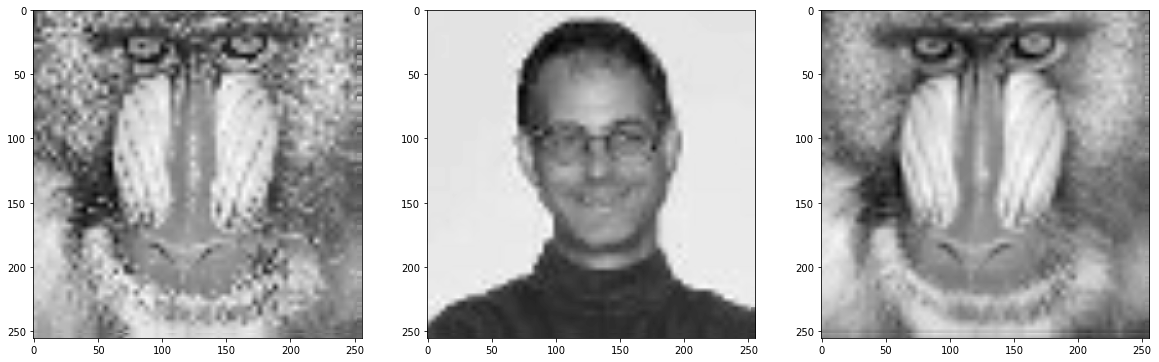

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_bilinear, cmap='gray')
ax[1].imshow(image_b_bilinear, cmap='gray')
ax[2].imshow(image_c_bilinear, cmap='gray')
plt.show()

## Espectro

In [174]:
spectrum = np.fft.fft2(original_image, s=(32, 632))

In [179]:
original_image.shape

(256, 256)

In [180]:
spectrum.shape

(32, 632)

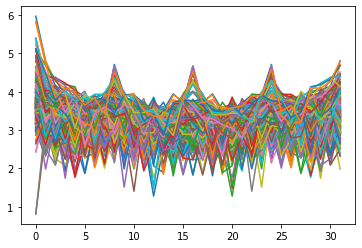

In [182]:
plt.plot(np.log10(abs(spectrum)))
plt.show()